# Results: Manual vs Automated Feature Engineering

In this notebook, we will compare the manual, and fully automated (Featuretools) feature engineering approaches for the Kaggle Home Credit Default Risk competition. For comparison we will focus on time: how long it took to make the features, and performance: the score in cross validation and when submitted to the Kaggle leaderboard. (We also include the features from the Semi-Automated Approach).

| Method                                       	| Total Features  before feature selection 	| Total Features  after feature selection 	| Time Spent (conservative estimate)| CV ROC AUC default model 	| CV ROC AUC  Optimized Model 	| Public Leaderboard ROC AUC optimized model 	|
|-----------------------------------------------	|------------------------------------------	|-----------------------------------------	|-------------------------------------------------------------------------------------------------------------------------------------------------------	|--------------------------	|-----------------------------	|--------------------------------------------	|
| Baseline  (Main table after one-hot encoding) 	| 241                                      	| 202                                     	| 15 minutes                                                                                                                                            	| 0.754497 (0.00600176)    	| 0.759222  (0.00522168)      	| 0.745                                      	|
| Manual Feature Engineering                    	| 271 (30 from  manual engineering)        	| 229 (26 from  manual engineering)       	| 10 hours                                                                                                                                              	| 0.772477  (0.00440231)   	| 0.78036  (0.00449839)       	| 0.786                                      	|
| Fully Automated                               	| 2109 (1850 from  featuretools)           	| 1040 (859 from featuretools)            	| 1 hour                                                                                                                                                	| 0.774754 (0.00151319)    	| 0.782407  (0.00120016)      	| 0.787                                      	|
| Manual + Semi-Automated                       	| 1445 (1173 from  semi-auto methods)      	| 878 (657 from  semi-auto methods)       	| 20 hours                                                                                                                                              	| 0.779672 (0.00566087)    	| 0.788476 (0.00435772)       	| 0.791                                      	|

  
## Explanation of Result Categories
   
* __Method__: refers to the method used to construct the set of features. The baseline is the main dataframe (`app`) after one-hot encoding categorical variables
* __Total Features before feature selection__: the total number of predictor variables after implementing the method. Numbers in parenthesis indicate the features built by the method alone since each method built on the baseline dataframe.
* __Total Features after feature selection__: number of features remaining after selection
* __Time Spent__: Total time spent creating the set of features including necessary domain understanding and implementing the code. This is a __conservative__ estimate as it does not include the hundreds of hours spent by other data scientists working on the problem.
* __CV ROC AUC default model__. The 5-fold cross validation ROC AUC using the default hyperparameter values of the Gradient Boosting Machine (GBM) implemented with the LightGBM library. The number of estimators was found using 100 rounds of early stopping with 5-fold cv. (Number in parenthesis is the standard deviation across five folds).
* __CV ROC AUC optimized model__. The 5-fold cross validation ROC AUC using the best hyperparameters from random search for 100 iterations on the respective sample of data. (Number in parenthesis is the standard deviation)
* __Public Leaderboard ROC AUC__. The ROC AUC score of dataset from the GBM model when submitted to the public leaderboard on Kaggle. The GBM model used the optimal hyperparameters and early stopping for the number of estimators. Predictions were made on the testing data and then uploaded to Kaggle where the Public Leaderboard is calculated using 10% of the total testing observations. The final leaderboard will be made known at the end of the competition. 
 
# Methodology
    
To assess the features, we want to perform several operations:,
    
1. Cross Validation (5 folds) ROC AUC with default GBM model in LightGBM library
2. Cross Validation (5 folds) ROC AUC with best hyperparameters from 100 iterations of random search on data sample
3. Public leaderboard ROC AUC from submitting predictions on testing data to Kaggle
4. Feature importances in the trained model

These steps are carried out in the `evaluate` function which can be found in the `utils.py` script.

## Random Search
   
The "optimal" hyperparameters of the GBM for each dataset were found by applying 100 iterations of random search to a sample of 10% of each set of training data. Performance was measured by the 5-fold cross validation ROC AUC using early stopping to determine the number of estimators to train. The gradient boosting machine was implemented in LightGBM. In addition to testing with the optimal hyperparameter values, we will assess the cross validation using the default hyperparameters to determine the relative effects of hyperparameter tuning versus feature engineering. 

### Roadmap 

1. Compare number of features built by each method
2. Evaluate each method in turn using the `evaluate` function.
3. Summarize results

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

# Evaluating dictionary
import ast

# Utilities developed in previous notebooks
from utils import format_data, plot_feature_importances, evaluate

RSEED = 50

/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Compare Number of Features

The first order of business is to compare the number of features created by each method that remain after feature selection. We can do this by loading in the first row of the data and comparing the column names.

In [2]:
train, test = pd.read_csv('../input/application_train.csv'), pd.read_csv('../input/application_test.csv')
test['TARGET'] = np.nan
train, test = pd.get_dummies(train).align(pd.get_dummies(test), axis = 1, join = 'inner')

original_features = list(train.columns)
manual_features = [x for x in pd.read_csv('../input/features_manual_selected.csv', nrows = 1).columns if x not in original_features]
auto_features = [x for x in pd.read_csv('../input/feature_matrix_select.csv', nrows = 1).columns if x not in original_features and x not in manual_features]
semi_features = [x for x in pd.read_csv('../input/features_semi_selected.csv', nrows = 1).columns if x not in original_features and x not in manual_features]

In [3]:
print("There were originally {} features.".format(len(original_features) - 2))
print("{} Manual Features remained after feature selection.".format(len(manual_features)))
print("{} Automated Features remained after feature selection.".format(len(auto_features)))
print("{} Semi-Automated Features remained after feature selection.".format(len(semi_features)))

There were originally 241 features.
26 Manual Features remained after feature selection.
859 Automated Features remained after feature selection.
657 Semi-Automated Features remained after feature selection.


This is no contest: automated feature engineering created many more features in about one tenth of the time. Even though all of these features will not be useful, having too many features is a better problem than having too few.

# Default Features

In [5]:
fm = pd.read_csv('../input/features_default_selected.csv')
hyp_results = pd.read_csv('../results/rs_features_default_sample_finished.csv', index_col=0)

results, feature_importances, submission = evaluate(fm, hyp_results)
results

Number of features:  203


default_auc default_auc_std   opt_auc opt_auc_std random_search_auc
0    0.754497      0.00600176  0.759222  0.00522168          0.748817

feature  importance  importance_normalized  \
0              AMT_GOODS_PRICE        9935               0.058110   
1                   DAYS_BIRTH        9694               0.056701   
2                 EXT_SOURCE_1        9053               0.052951   
3                  AMT_ANNUITY        9046               0.052910   
4                 EXT_SOURCE_3        8714               0.050969   
5                 EXT_SOURCE_2        8287               0.048471   
6              DAYS_ID_PUBLISH        7830               0.045798   
7       DAYS_LAST_PHONE_CHANGE        7766               0.045424   
8                DAYS_EMPLOYED        7327               0.042856   
9            DAYS_REGISTRATION        6718               0.039294   
10                  Unnamed: 0        5712               0.033410   
11  REGION_POPULATION_RELATIVE        4952               0.028964   
12            AMT_INCOME_TOTAL        4576               0.026765   
13                 OWN_CAR_AGE        3746               0.021911   
14               LANDAREA_MODE        3307               0.019343   

    cumulative_importance  
0                0.058110  
1                0.114811  
2                0.167762  
3                0.220673  
4                0.271641  
5                0.320113  
6                0.365911  
7                0.411334  
8                0.454190  
9                0.493484  
10               0.526894  
11               0.555858  
12               0.582624  
13               0.604534  
14               0.623877

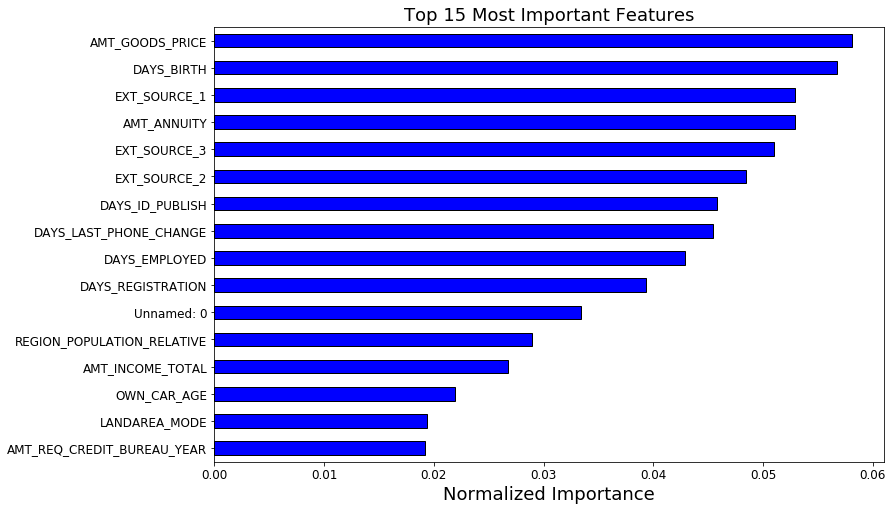

In [6]:
results.to_csv('../results/default_results.csv', index = False)
submission.to_csv('../submissions/default_submission.csv', index = False)

norm_feature_importances = plot_feature_importances(feature_importances)
norm_feature_importances.to_csv('../results/default_fi.csv', index = False)
norm_feature_importances.head(15)

The default features - base `app` dataframe after one-hot encoding do fairly well by themselves. This says there was already a considerable amount of useful information in the main dataframe.

This model scores __0.745__ when submitted to the competition. 

# Manual Engineered Features

In [7]:
fm = pd.read_csv('../input/features_manual_selected.csv')
hyp_results = pd.read_csv('../results/rs_features_manual_sample_finished.csv', index_col=0)

results, feature_importances, submission = evaluate(fm, hyp_results)
results

Number of features:  228


default_auc default_auc_std  opt_auc opt_auc_std random_search_auc
0    0.772477      0.00440231  0.78036  0.00449839          0.760968

The manual engineered features do considerably better than the baseline features. If we compare the score when submitted to the competition, the manual features do 66% better than the baseline relative to the top score on the leaderboard. This speaks to the importance of proper feature engineering! 

## Manual Feature Importances

feature  importance  importance_normalized  \
0                       LOAN_RATE        8184               0.058929   
1                    EXT_SOURCE_3        4680               0.033698   
2                   DAYS_EMPLOYED        4329               0.031171   
3                      DAYS_BIRTH        4210               0.030314   
4        CASH_AVERAGE_LOAN_LENGTH        4043               0.029111   
5         PREVIOUS_LOAN_RATE_MEAN        4021               0.028953   
6   PREVIOUS_LOAN_DIFFERENCE_MEAN        3949               0.028435   
7                    EXT_SOURCE_1        3839               0.027643   
8                 EXT_SOURCE_MEAN        3814               0.027463   
9         PREVIOUS_OTHER_LOAN_SUM        3809               0.027427   
10                    AMT_ANNUITY        3599               0.025914   
11                   EXT_SOURCE_2        3586               0.025821   
12                DAYS_ID_PUBLISH        3428               0.024683   
13             INSTALLMENTS_COUNT        3305               0.023798   
14                    CASH_COUNTS        3259               0.023466   

    cumulative_importance  
0                0.058929  
1                0.092627  
2                0.123798  
3                0.154111  
4                0.183223  
5                0.212176  
6                0.240611  
7                0.268253  
8                0.295716  
9                0.323142  
10               0.349057  
11               0.374878  
12               0.399561  
13               0.423358  
14               0.446825

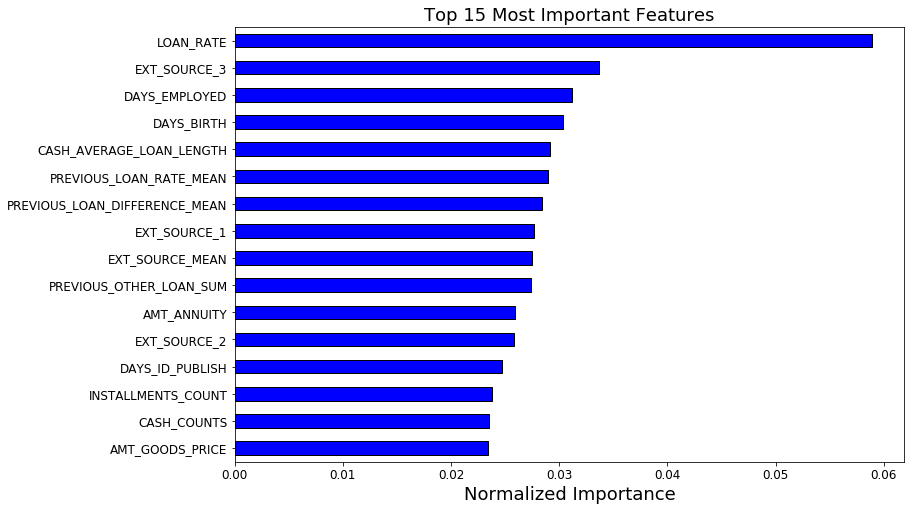

In [8]:
results.to_csv('../results/manual_results.csv', index = False)
submission.to_csv('../submissions/manual_submission.csv', index = False)

norm_feature_importances = plot_feature_importances(feature_importances)
norm_feature_importances.to_csv('../results/manual_fi.csv', index = False)
norm_feature_importances.head(15)

The most important feature, `LOAN_RATE`, was one of those that we made by hand. We also created several of the other most important features indicating that all of our time was not spent in vain on feature engineering.

These predictions score __0.786__ on the leaderboard when submitted.

# Automated Features Using Featuretools

In [9]:
fm = pd.read_csv('../input/feature_matrix_selected.csv')
hyp_results = pd.read_csv('../results/rs_feature_matrix_sample_finished.csv', index_col=0)

results, feature_importances, submission = evaluate(fm, hyp_results)
results

Number of features:  1040


default_auc default_auc_std   opt_auc opt_auc_std random_search_auc
0    0.774754      0.00151319  0.782407  0.00120016          0.765772

The automated engineered features outperform the manual features both in terms of cross-validation on the training data and when submitted to the competition. The score is 67% higher than the baseline measured relative to the top leaderboard score (as of this writing). We can also see that model hyperparameter tuning does affect the final performance to a small degree, considerably less than feature engineering.

## Automated Feature Importances

feature  importance  \
0                       PERCENTILE(EXT_SOURCE_2)        1470   
1                       PERCENTILE(EXT_SOURCE_1)        1460   
2                       PERCENTILE(EXT_SOURCE_3)        1381   
3                                     DAYS_BIRTH        1155   
4                    PERCENTILE(AMT_GOODS_PRICE)        1085   
5                        PERCENTILE(AMT_ANNUITY)         908   
6                                  DAYS_EMPLOYED         816   
7                                AMT_GOODS_PRICE         812   
8                                    AMT_ANNUITY         809   
9                                DAYS_ID_PUBLISH         781   
10                     PERCENTILE(DAYS_EMPLOYED)         775   
11  MEAN(previous.MIN(installments.AMT_PAYMENT))         741   
12                             DAYS_REGISTRATION         656   
13                        DAYS_LAST_PHONE_CHANGE         648   
14                       PERCENTILE(OWN_CAR_AGE)         606   

    importance_normalized  cumulative_importance  
0                0.014791               0.014791  
1                0.014690               0.029481  
2                0.013895               0.043377  
3                0.011621               0.054998  
4                0.010917               0.065915  
5                0.009136               0.075052  
6                0.008210               0.083262  
7                0.008170               0.091432  
8                0.008140               0.099572  
9                0.007858               0.107431  
10               0.007798               0.115229  
11               0.007456               0.122685  
12               0.006601               0.129285  
13               0.006520               0.135805  
14               0.006097               0.141903

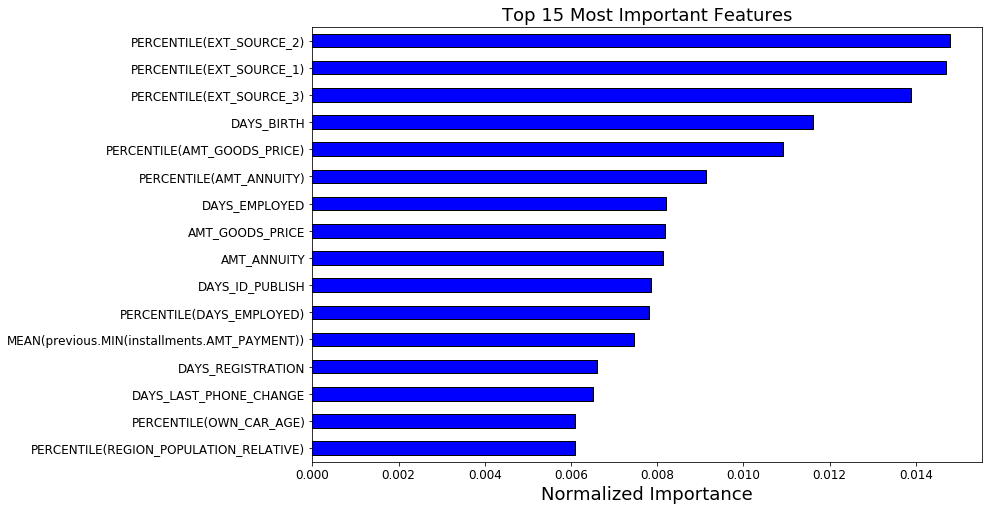

In [10]:
results.to_csv('../results/auto_results.csv', index = False)
submission.to_csv('../submissions/auto_submission.csv', index = False)

norm_feature_importances = plot_feature_importances(feature_importances)
norm_feature_importances.to_csv('../results/auto_fi.csv', index = False)
norm_feature_importances.head(15)

Many of the most important features were ones created by Featuretools. Moreover, one of the features has a depth of 2, and might not even be a feature we would consider building by hand. While automated feature engineering did not create all of the same features as manual for this problem (we could have by using a `divide` transformation primitive), it still created an extremely useful set that overall resulted in a better predictive model.

These features score __0.787__ when submitted.

# Semi-Automated Features

The semi-automated features were built in the Semi Automated Notebook. This is a more efficient approach than manual feature engineering, but raises the question of why not go fully-automated? The semi automated approach basically was an implementation of Featuretools that took about 10 times as long! These features were combined with the manual features (since once we have those we might as well use them).

In [11]:
fm = pd.read_csv('../input/features_semi_selected.csv')
hyp_results = pd.read_csv('../results/rs_features_semi_sample_finished.csv', index_col=0)

results, feature_importances, submission = evaluate(fm, hyp_results)
results

Number of features:  878


default_auc default_auc_std   opt_auc opt_auc_std random_search_auc
0    0.779672      0.00566087  0.788476  0.00435772          0.775374

## Semi-Automated Feature Importances

feature  importance  importance_normalized  \
0                        LOAN_RATE        1915               0.026934   
1                       DAYS_BIRTH        1117               0.015710   
2                  EXT_SOURCE_MEAN        1047               0.014726   
3                     EXT_SOURCE_3        1042               0.014655   
4                    DAYS_EMPLOYED        1003               0.014107   
5                      AMT_ANNUITY         980               0.013783   
6                     EXT_SOURCE_1         887               0.012475   
7                     EXT_SOURCE_2         867               0.012194   
8                  AMT_GOODS_PRICE         760               0.010689   
9           BUREAU_DAYS_CREDIT_max         751               0.010563   
10                  EXT_SOURCE_SUM         699               0.009831   
11                 DAYS_ID_PUBLISH         695               0.009775   
12             CREDIT_INCOME_RATIO         687               0.009662   
13    BUREAU_DAYS_ENDDATE_FACT_max         644               0.009058   
14  BUREAU_DAYS_CREDIT_ENDDATE_max         625               0.008790   

    cumulative_importance  
0                0.026934  
1                0.042644  
2                0.057370  
3                0.072025  
4                0.086132  
5                0.099916  
6                0.112391  
7                0.124585  
8                0.135274  
9                0.145837  
10               0.155668  
11               0.165443  
12               0.175105  
13               0.184163  
14               0.192954

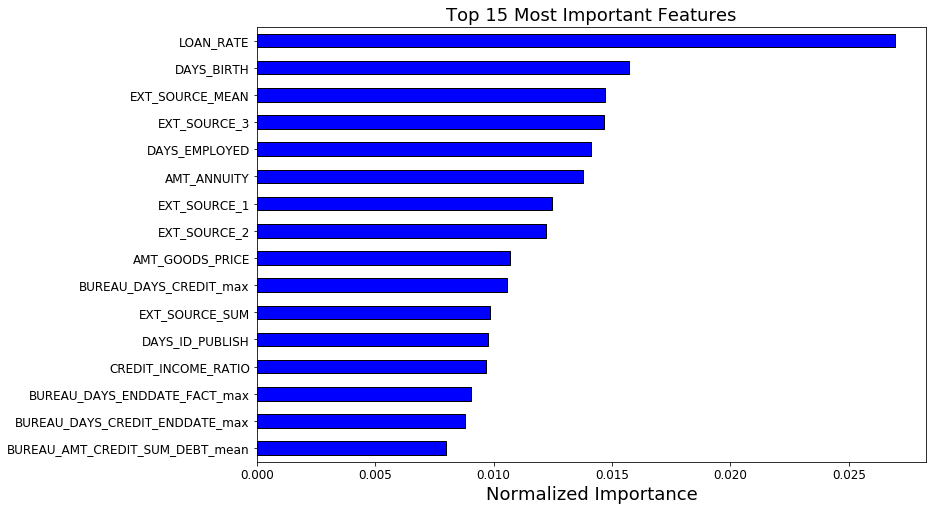

In [12]:
results.to_csv('../results/semi_results.csv', index = False)
submission.to_csv('../submissions/semi_submission.csv', index = False)

norm_feature_importances = plot_feature_importances(feature_importances)
norm_feature_importances.to_csv('../results/semi_fi.csv', index = False)
norm_feature_importances.head(15)

Some of the semi-automated features (those ending in `max` or `mean`) are among the most important. The most important feature is still that made from manual feature engineering. Overall, the performance of this dataset was slightly better than either manual or fully automated but came at the greatest overall time investment (20 hours). At a certain point, accuracy becomes less important than interpretability.

This dataset scores __0.791__ when submitted to the competition.

# Combine Manual and Automated Feature Matrices

As an interesting experiment, we can combine the manual and automated engineering features and see what the results are. As long as the features do not exactly overlap, we should expect the model to perform better because either of the datasets on their own do better than the baseline. However, it could be possible that all the features in the manual engineering features are recreated in the automated feature engineering matrix.

In [13]:
fm_manual = pd.read_csv('../input/features_manual_selected.csv')
fm_auto = pd.read_csv('../input/feature_matrix_selected.csv')
fm_auto = fm_auto[[x for x in fm_auto if x not in fm_manual]]
fm = pd.concat([fm_manual, fm_auto], axis = 1)
fm.shape

(356255, 1091)

In [14]:
hyp_results = pd.read_csv('../results/rs_feature_matrix_sample_finished.csv', index_col=0)

results, feature_importances, submission = evaluate(fm, hyp_results)
results

Number of features:  1089


default_auc default_auc_std  opt_auc opt_auc_std random_search_auc
0    0.769057      0.00506485  0.77465  0.00456319          0.765772

In [15]:
submission.to_csv('../submissions/combined_submission.csv', index = False)

The combined data does not do as well as either of the datasets by themselves. This could be because there is an overlap between the features that leads to more useful features being hidden behind less useful features. We also are using the best hyperparameters from the automated feature matrix which do not necessarily translate to the best hyperparameters for this new dataset. It's possible that these features would be better after feature selection or after model hyperparameter tuning using random search on this data.

# Conclusions

With the results presented below, this project is now complete. What we have learned is that with only a few minutes of programming, Featuretools is able to get us to a level comparable with dozens of hours of manual feature engineering on a real-world data science problem.

| Dataset                                       	| Total Features  before feature selection 	| Total Features  after feature selection 	| Time Spent  (conservative  estimate) 	| CV ROC AUC default model 	| CV ROC AUC  Optimized Model 	| Public Leaderboard ROC AUC optimized model 	|
|-----------------------------------------------	|------------------------------------------	|-----------------------------------------	|--------------------------------------	|--------------------------	|-----------------------------	|--------------------------------------------	|
| Baseline  (Main table after one-hot encoding) 	| 241                                      	| 203                                     	| 15 minutes                           	| 0.754497 (0.00600176)    	| 0.759222  (0.00522168)      	| 0.745                                      	|
| Manual Feature Engineering                    	| 271 (30 from  manual engineering)        	| 231 (26 from  manual engineering)       	| 10 hours                             	| 0.772477  (0.00440231)   	| 0.78036  (0.00449839)       	| 0.786                                      	|
| Fully Automated                               	| 2091 (1850 from  featuretools)           	| 1042 (859 from featuretools)            	| 1 hour                               	| 0.774754 (0.00151319)    	| 0.782407  (0.00120016)      	| 0.787
            |
| Manual + Semi-Automated                       	| 1444 (1173 from  semi-auto methods)      	| 880 (657 from  semi-auto methods)       	| 20 hours                             	| 0.779672 (0.00566087)    	| 0.788476 (0.00435772)       	| 0.791                                      	|
                                      	
The takeaways from this project are:

* Automated feature engineering with Featuretools is able to achieve results comparable or better than manual feature engineering with a 10x gain in speed
* Feature engineering undoubtedly adds value to the problem and is a necessity in a data science pipeline
* Model hyperparameter tuning has an appreciable affect on performance although less than feature engineering
* The code we wrote for Featuretools is broadly applicable to any data science problem while the manual feature engineering code is problem specific
* Automated feature engineering should be a standard part of the machine learning pipeline because it is able to increase efficiency while delivering performance exceeding that of manual approaches

__Feature engineering is a must for any data science problem and although manual feature engineering does work, if there is a more efficient method to get the same or better results, then it's only logical to use that method!__ Overall, automated feature engineering with Featuretools reduced development time by at least 10x, delivered the same performance, and also created interpretable features that we would not have thought of ourselves. Moreover, as can be seen in the other projects, the same Featuretools code can be applied to other datasets with only minor modifications. __Automated feature engineering will be a standard part of the machine learning pipeline, enabling better predictive models with a smaller time investment.__